In [1]:
import kagglehub
import pandas as pd
import os
from PIL import Image
import numpy as np
import torch 
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import seaborn as sns



# EDA


In [2]:
# Download latest version
path = kagglehub.dataset_download("gpreda/chinese-mnist")

print("Path to dataset files:", path)

# Load the dataset into a pandas DataFrame
csv_file_path = f"{path}/chinese_mnist.csv"
dataDF = pd.read_csv(csv_file_path)


# Print the feature names (column names)
print("Feature names:", dataDF.columns.tolist())

100%|██████████| 16.5M/16.5M [00:02<00:00, 8.04MB/s]

Extracting model files...


Path to dataset files: C:\Users\angel\.cache\kagglehub\datasets\gpreda\chinese-mnist\versions\7
Feature names: ['suite_id', 'sample_id', 'code', 'value', 'character']


In [3]:
IMAGE_PATH = f"{path}/data/data/"
print("image files :", len(os.listdir(IMAGE_PATH)))

# Add file name to the data frame
dataDF['file'] = dataDF[['suite_id','sample_id','code']].apply(lambda x: 'input_' + 
                 x['suite_id'].astype(str) +'_'+x['sample_id'].astype(str)+'_'+x['code'].astype(str)+'.jpg', axis=1)
dataDF.head(5)



image files : 15000


,suite_id,sample_id,code,value,character,file
0,1,1,10,9,九,input_1_1_10.jpg
1,1,10,10,9,九,input_1_10_10.jpg
2,1,2,10,9,九,input_1_2_10.jpg
3,1,3,10,9,九,input_1_3_10.jpg
4,1,4,10,9,九,input_1_4_10.jpg


In [11]:
indexImage = 3000
imgPath =  os.path.join(IMAGE_PATH, dataDF['file'][indexImage]) 
im = Image.open(imgPath)
im.size
IMG_SIZE = im.size[0]

# Data Preparation

In [5]:
class ChineseMNISTdataset(Dataset):
    def __init__(self, annotations_dataframe, img_dir):
        self.df = annotations_dataframe
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        imgPath =  os.path.join(self.img_dir, self.df ['file'][idx]) 
        img = Image.open(imgPath)

        imgAsT = torch.from_numpy(np.array(img)).float()

        label = self.df['code'][idx] -1 # let's use the code as target variable
        
        return imgAsT, label

In [6]:
chineseNumbers = ChineseMNISTdataset(dataDF, IMAGE_PATH)  # init
chineseNumbers.__len__() # dataset length

15000

torch.Size([64, 64])
9
15000


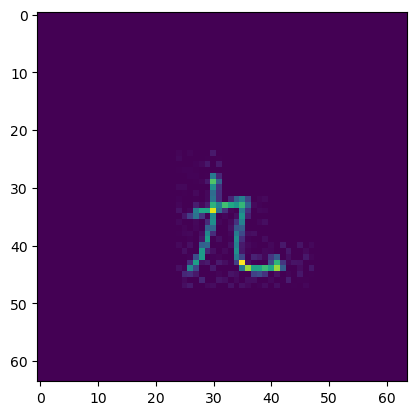

In [33]:
img, label = chineseNumbers.__getitem__(42)
print(img.shape)
print(label)
plt.imshow(img)
print(len(chineseNumbers))


# Split data for training and testing

In [8]:
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

In [9]:
testSize = chineseNumbers.__len__() // 10
trainSize = chineseNumbers.__len__() - testSize

trainDataset, testDataset = random_split(chineseNumbers, [trainSize, testSize])

len(trainDataset), len(testDataset)

(13500, 1500)

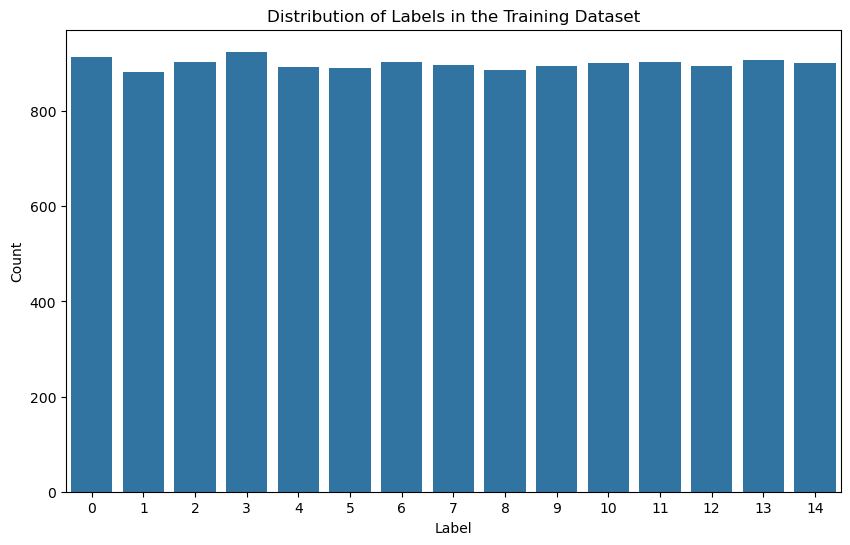

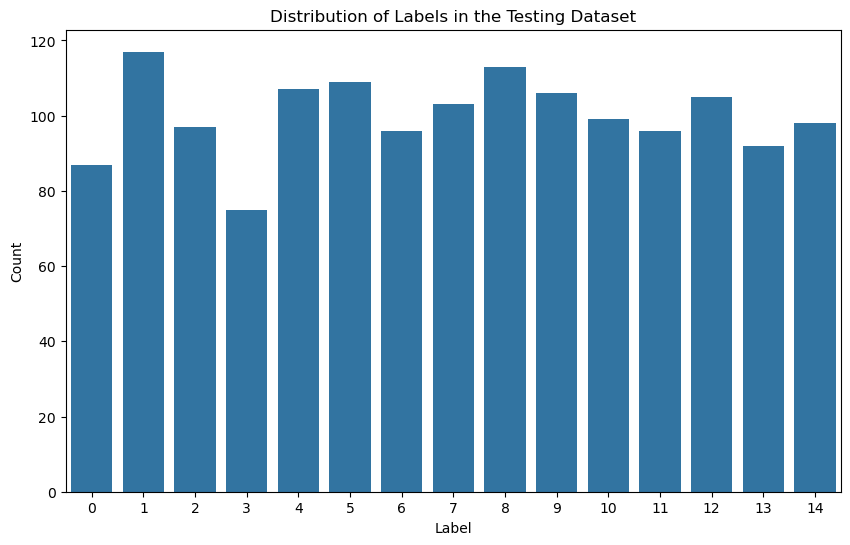

In [10]:
# Extract labels from the training dataset
train_labels = [trainDataset[i][1] for i in range(len(trainDataset))]

# Convert training labels to a pandas DataFrame
train_labels_df = pd.DataFrame(train_labels, columns=['label'])

# Extract labels from the testing dataset
test_labels = [testDataset[i][1] for i in range(len(testDataset))]

# Convert testing labels to a pandas DataFrame
test_labels_df = pd.DataFrame(test_labels, columns=['label'])

# Visualize the distribution of the labels for the training dataset
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_labels_df)
plt.title('Distribution of Labels in the Training Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Visualize the distribution of the labels for the testing dataset
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=test_labels_df)
plt.title('Distribution of Labels in the Testing Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
labels_dict = {
    0: "零", 1: "一", 2: "二", 3: "三", 4: "四", 5: "五",
    6: "六", 7: "七", 8: "八", 9: "九", 10: "十",
    11: "百", 12: "千", 13: "万", 14: "亿"
}


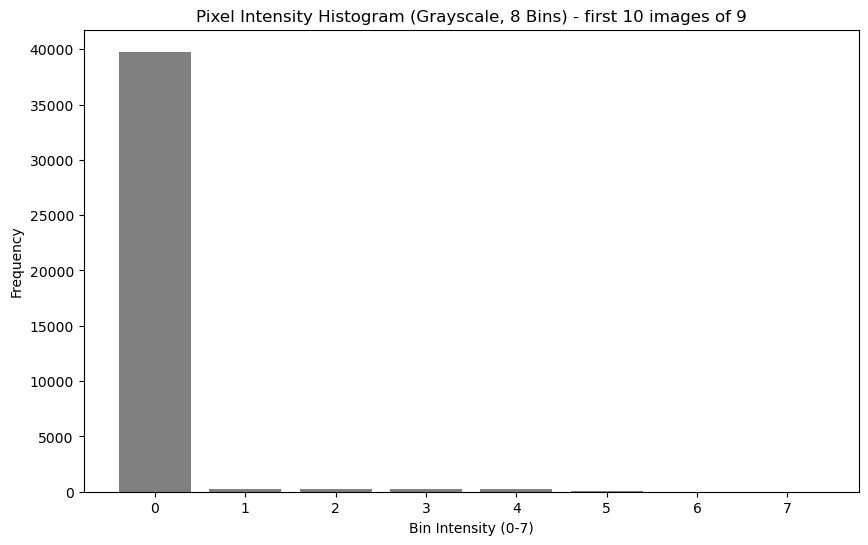

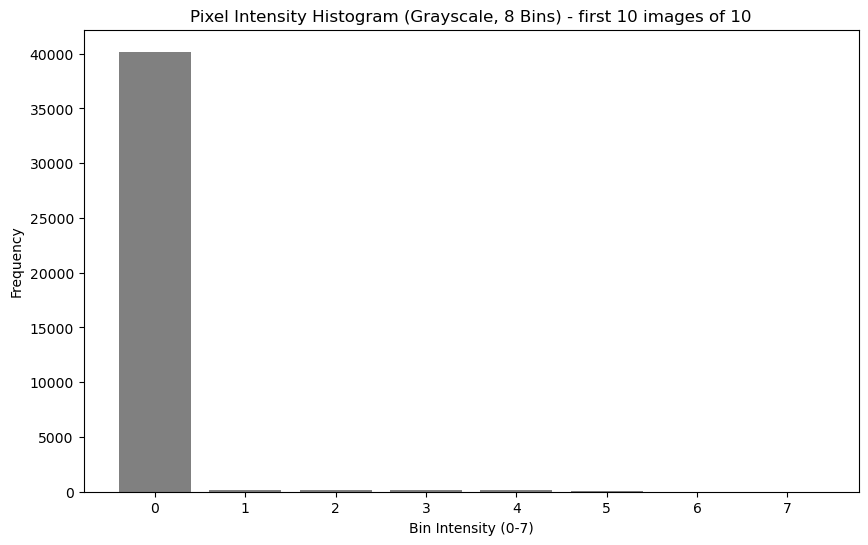

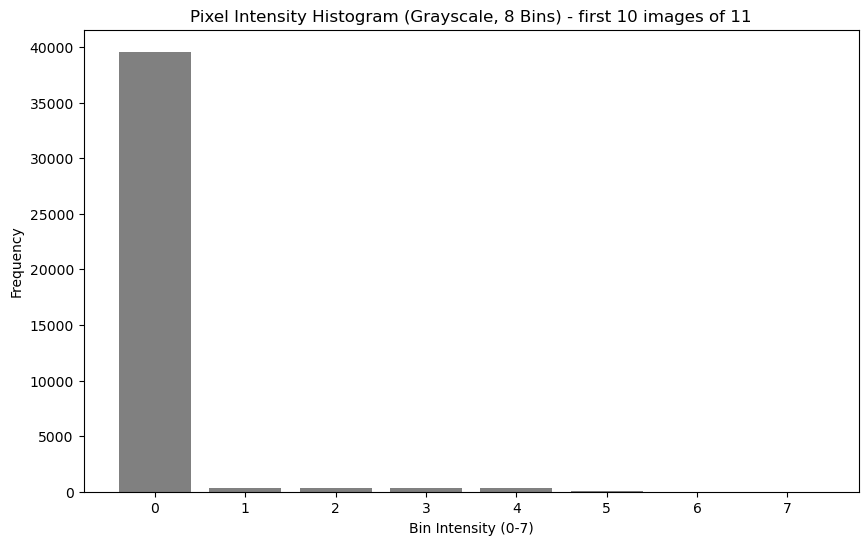

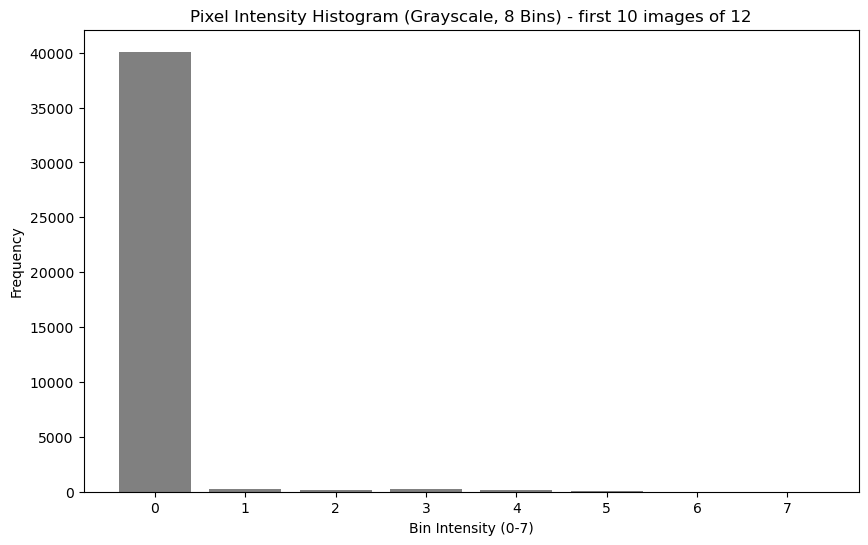

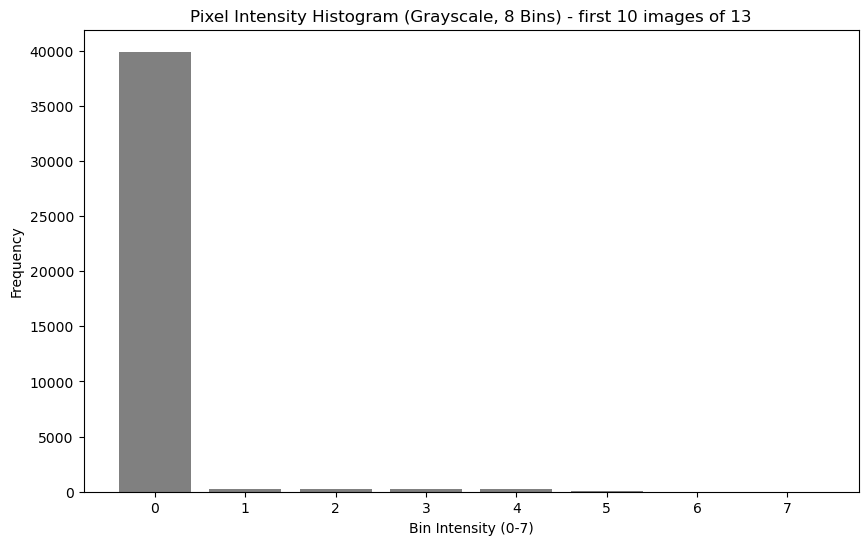

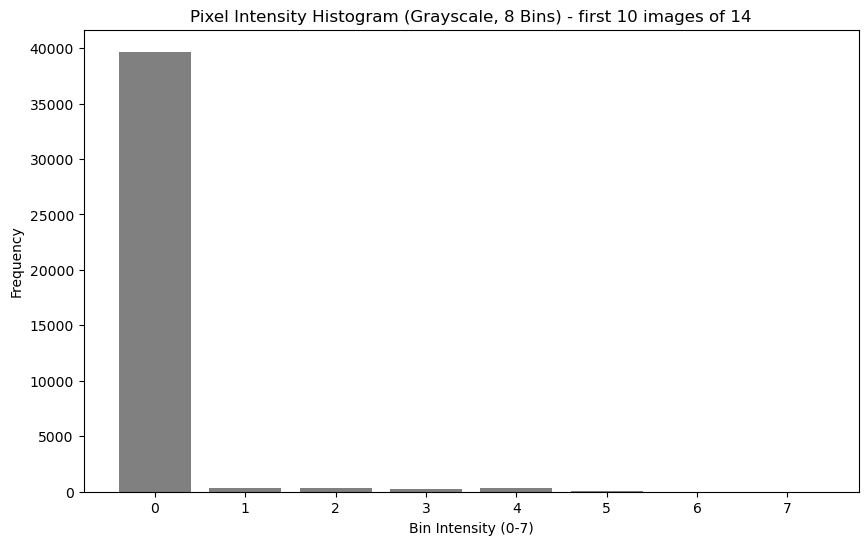

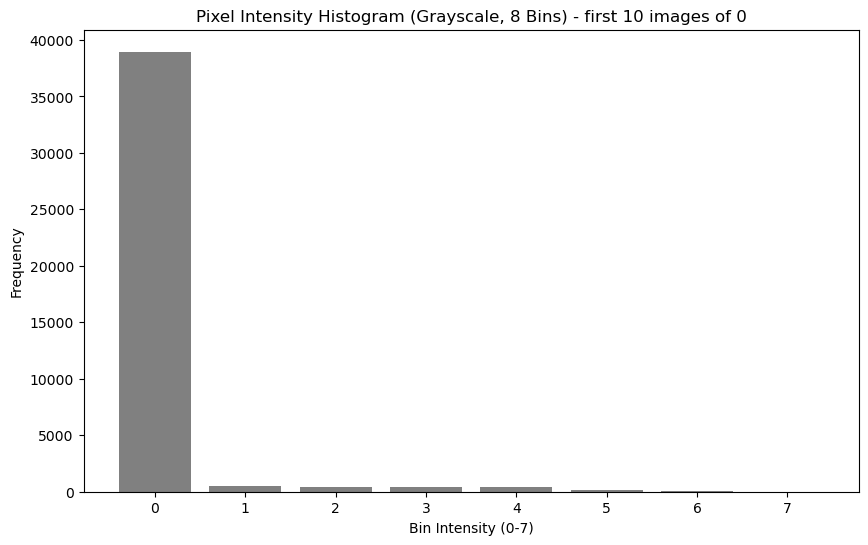

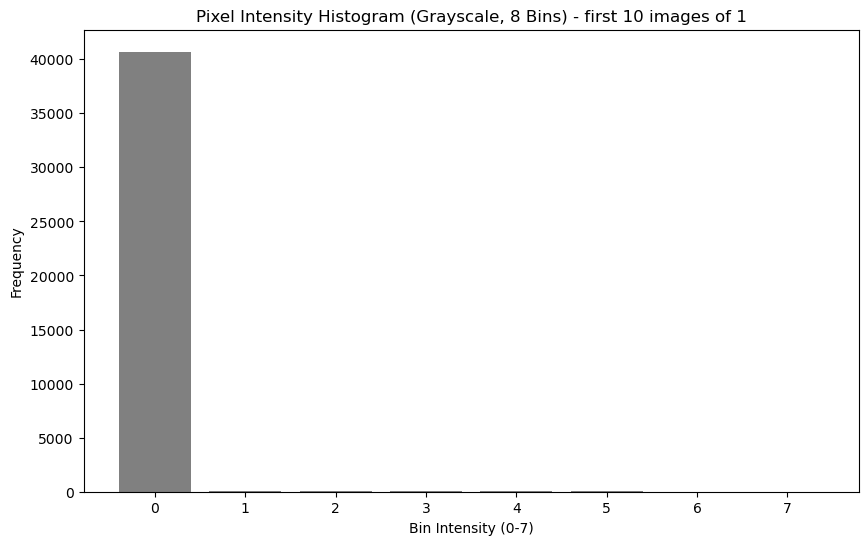

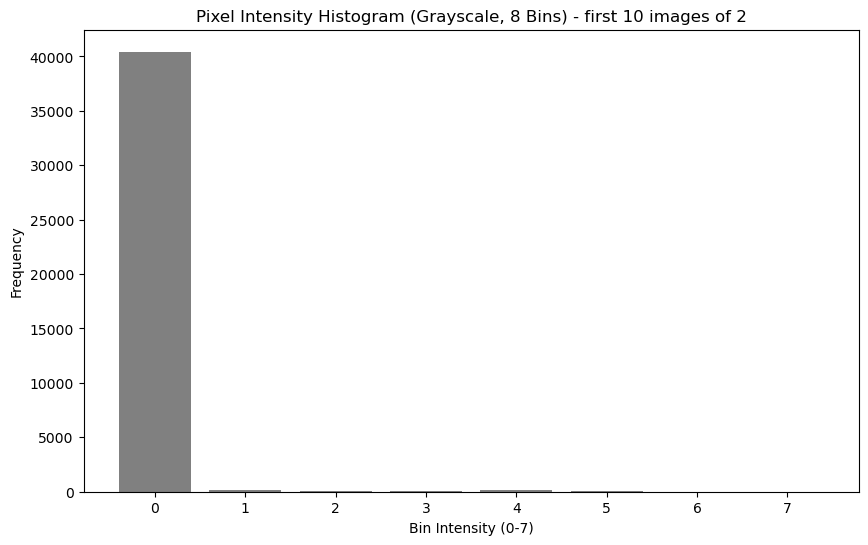

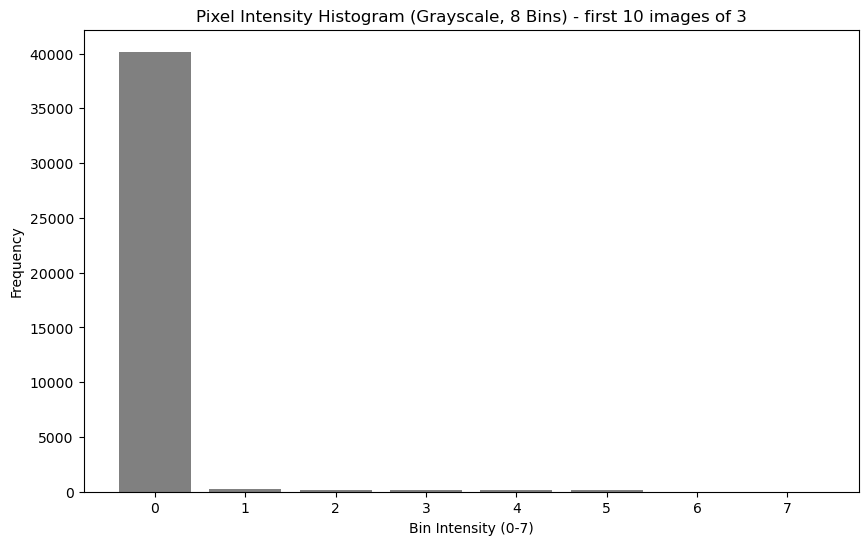

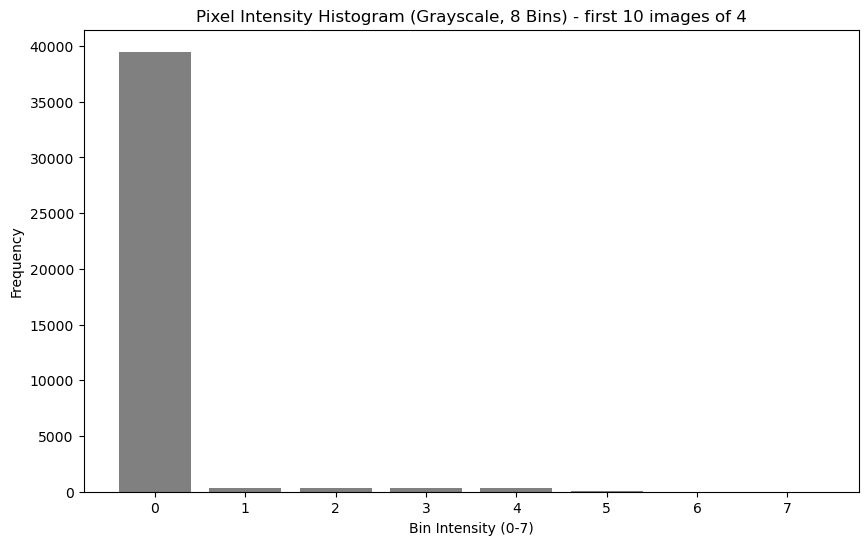

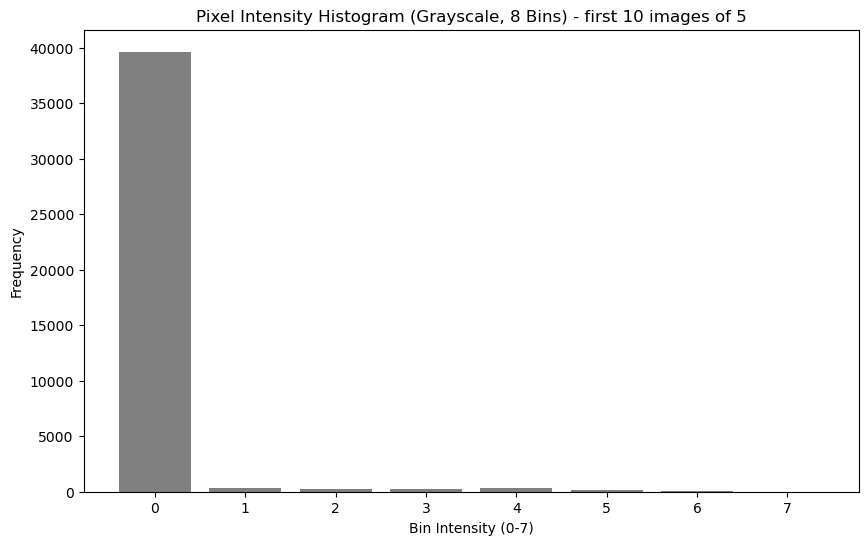

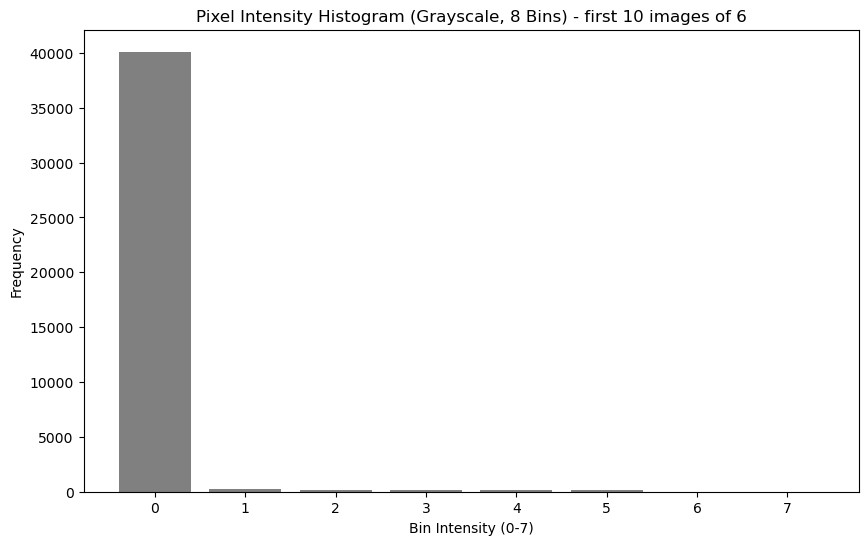

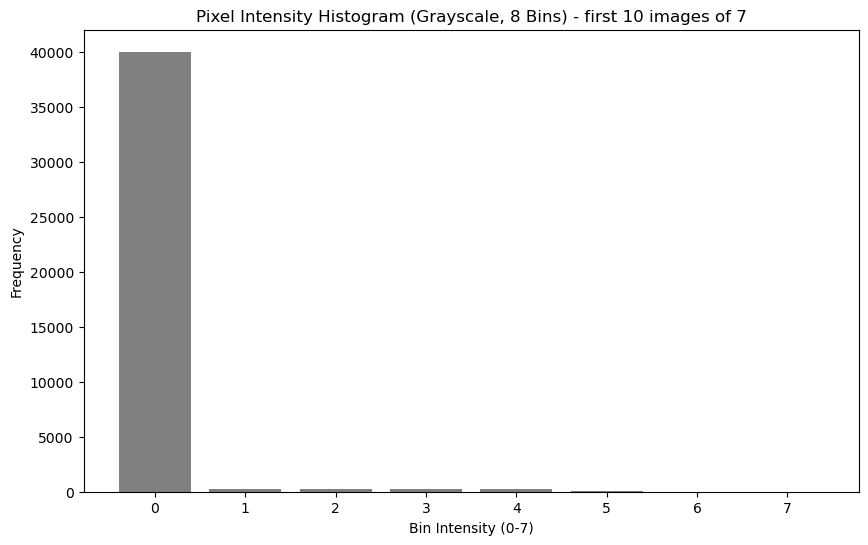

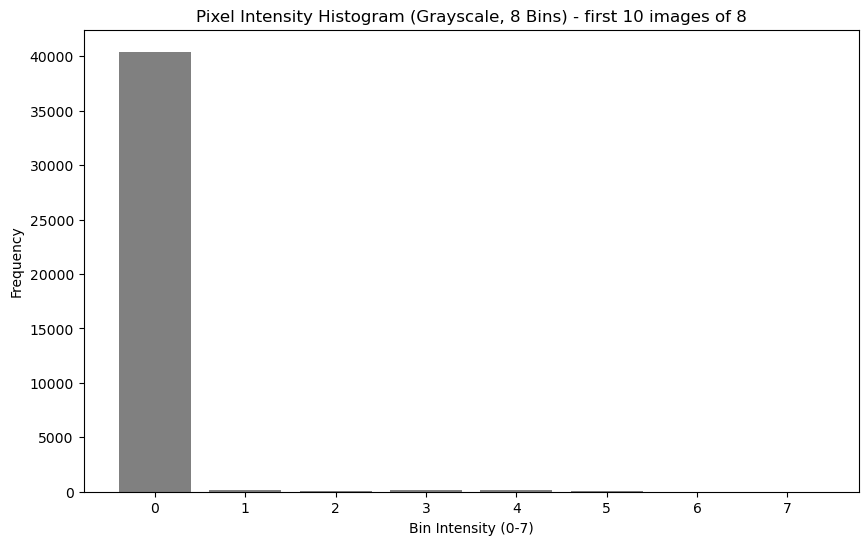

In [41]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(0, 15000, 1000):
    accumulated_hist = np.zeros(8)
    
    # Accumulate histogram for 10 images starting from each `i` value
    for j in range(i, i + 10):
        img, label = chineseNumbers.__getitem__(j)  # Get the numpy array for each image
        
        # Flatten the array to 1D for histogram calculation
        img_array = img.flatten()  # Flatten to ensure 1D array for histogram
        
        # Calculate the histogram with 8 bins over the full range of 0 to 255
        hist, _ = np.histogram(img_array, bins=8, range=(0, 256))
        accumulated_hist += hist
        
    # Plot the accumulated histogram for this batch of 10 images
    plt.figure(figsize=(10, 6))
    plt.bar(range(8), accumulated_hist, color='gray', tick_label=range(8)) 
    plt.xlabel('Bin Intensity (0-7)')
    plt.ylabel('Frequency')
    plt.title(f'Pixel Intensity Histogram (Grayscale, 8 Bins) - first 10 images of {labels_dict[label]}')
    plt.show()
